https://www.pinecone.io/learn/series/image-search/zero-shot-image-classification-clip/

In [29]:
from transformers import CLIPProcessor, CLIPModel
import torch, numpy as np, os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.axes as axes

In [6]:
def tokenize_labels(processor, text_batch, device):
  return processor(text=text_batch, padding=True, images=None, return_tensors='pt').to(device)

In [ ]:
# Initialize models

model_id = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [9]:
classes = ["cigarette", "popsicle stick"]
labels = [f"a photo of a {c}" for c in classes]
label_emb = model.get_text_features(**tokenize_labels(processor, labels, device))
label_emb = label_emb.detach().cpu().numpy()
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.shape

(2, 512)

In [24]:
folder_of_images = "pytorch-CycleGAN-and-pix2pix/results/smoking/test_latest/images"
first_few_paths = list(os.listdir(folder_of_images))[:10]
first_few = [Image.open(os.path.join(folder_of_images, img_path)).convert("RGB") for img_path in first_few_paths]

In [16]:
image = processor(
    text=None,
    images=first_few,
    return_tensors='pt'
)['pixel_values'].to(device)
img_emb = model.get_image_features(image)
img_emb.shape
img_emb = img_emb.detach().cpu().numpy()
img_emb = img_emb / np.linalg.norm(img_emb, axis=0)

In [26]:
scores = np.dot(img_emb, label_emb.T)
pred = np.argmax(scores, axis=1)
for i, v in enumerate(first_few_paths):
  print(f"[{i}] Img: {v}: {classes[pred[i]]}")

[0] Img: 000007_fake_A.png: cigarette
[1] Img: 000011_fake_A.png: cigarette
[2] Img: 000039_real_A.png: cigarette
[3] Img: 000058_fake_A.png: popsicle stick
[4] Img: 000012_rec_A.png: popsicle stick
[5] Img: 000006_fake_B.png: cigarette
[6] Img: 000010_fake_B.png: cigarette
[7] Img: 000059_fake_B.png: cigarette
[8] Img: 000013_rec_A.png: cigarette
[9] Img: 000037_fake_B.png: cigarette


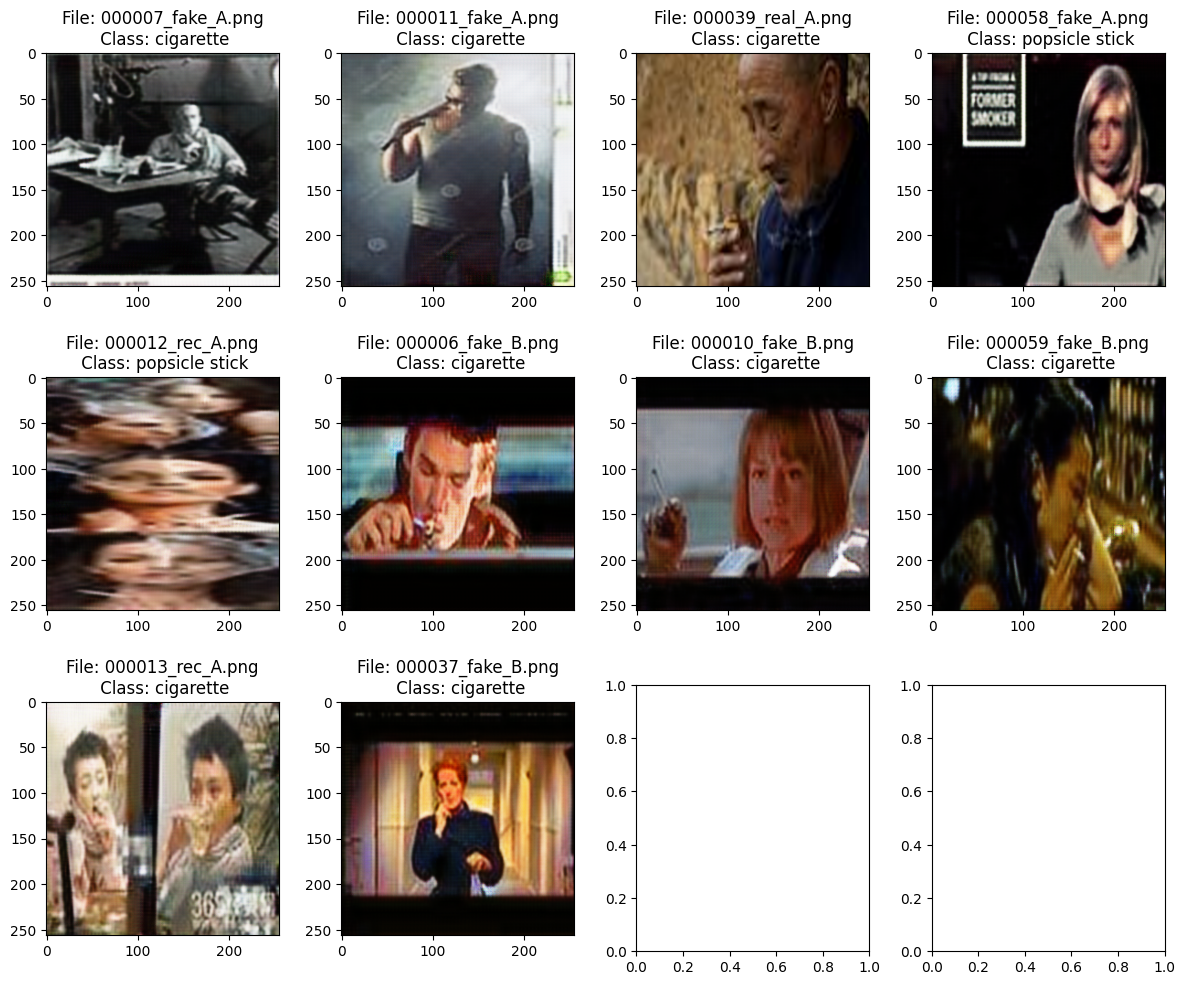

In [34]:
fig, axs = plt.subplots(3, 4, figsize=(12, 10))
axs = axs.flatten()
for i, path in enumerate(first_few_paths):
  ax = axs[i]
  ax: axes.Axes
  ax.imshow(first_few[i])
  ax.set_title(f"File: {first_few_paths[i]}\nClass: {classes[pred[i]]}")
fig.tight_layout()